In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM
import matplotlib.pyplot as plt

# 1. Transforming Data
We first transform the data into logarithms to stabilise the variance and to be able to interpet the variables as approximate growth rates. We also re-format the index to monthly data to address fromating issues in the forecasting dataset later on.

In [8]:
df_log

,CPIH,AWE,Productivity,CPIH_ln,AWE_ln,Prod_ln
Month,,,,,,
2000-01-01,72.6,304.722925,82.5,4.284965,5.719403,4.412798
2000-02-01,72.8,299.818577,82.5,4.287716,5.703178,4.412798
2000-03-01,73.0,311.418715,82.5,4.290459,5.741138,4.412798
2000-04-01,73.3,308.748756,82.2,4.294561,5.732528,4.409155
2000-05-01,73.5,311.178774,82.2,4.297285,5.740368,4.409155
...,...,...,...,...,...,...
2025-04-01,137.7,719.763788,99.0,4.925077,6.578923,4.595120
2025-05-01,138.0,722.569363,99.0,4.927254,6.582813,4.595120
2025-06-01,138.4,724.738409,99.0,4.930148,6.585811,4.595120


In [7]:
df_model = pd.read_csv('data/preprocessed/dataset.csv')

df_log = df_model.copy()

# Converting month to datetime and setting as index
df_log['Month'] = pd.to_datetime(df_log['Month'])
df_log = df_log.set_index('Month')
# Monthly start frequency
df_log = df_log.asfreq('MS')

# Log Transformations
for c in ['CPIH', 'AWE', 'Productivity']:
    if c == 'Productivity':
        df_log['Prod_ln'] = np.log(df_log[c])
    else:
        df_log[f'{c}_ln'] = np.log(df_log[c])


# 2. Stationarity Tests
We test for stationarity using both the Augmented Dickey-Fuller test and the KPSS test.

## Augmented Dickey Fuller
Tests the null that a unit root exists in a time-series,
We then take the difference and reject the null at 1% level, the series is stationary and integrated at order one I(1)

# KPSS test
We test the null of stationarity again. We strongly reject the null and conclude that the variables are non-stationary.

In [9]:
# Log column list
cols = ['CPIH_ln', 'AWE_ln', 'Prod_ln']
# Running unit root test for each variable
print("Dickey Fuller Test for log variables")
for col in cols:
    adf_test = adfuller(df_log[col], autolag='AIC')[1]
    print(f"{col} : {adf_test}")
# Fail to reject the null of non-stationarity
# Prod_ln can reject then null of unit root at 10% but not 5%

#Taking first difference
df_log_diff = df_log[cols].diff().dropna()
#Running unit roots tests for differenced variables
print("\nDickey Fuller Test for log variables - 1st difference")
for col in cols:
    adf_test = adfuller(df_log_diff[col], autolag='AIC')[1]
    print(f"{col} : {adf_test}")
# We reject the null at 1% level, the differenced series are stationary

# Testing for trend stationarity using KPSS
print("\nKPSS Test for log variables")
for col in cols:
    stat, p, lags, crit = kpss(df_log[col].dropna(), regression='c', nlags='auto')
    print(f"{col} KPSS statistic : {stat}")
    print(f"{col} p-value: {p}\n")
# We can confidently reject the null of stationarity using both tests

Dickey Fuller Test for log variables
CPIH_ln : 0.9978836013850167
AWE_ln : 0.988713743086515
Prod_ln : 0.09409055828814583

Dickey Fuller Test for log variables - 1st difference
CPIH_ln : 0.014480752737135996
AWE_ln : 1.81475465994484e-29
Prod_ln : 1.7210911248880824e-07

KPSS Test for log variables
CPIH_ln KPSS statistic : 2.5874281123825575
CPIH_ln p-value: 0.01

AWE_ln KPSS statistic : 2.5370534837531893
AWE_ln p-value: 0.01

Prod_ln KPSS statistic : 2.5335623841141586
Prod_ln p-value: 0.01



C:\Users\andre\AppData\Local\Temp\ipykernel_72124\1065861635.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, crit = kpss(df_log[col].dropna(), regression='c', nlags='auto')
C:\Users\andre\AppData\Local\Temp\ipykernel_72124\1065861635.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, crit = kpss(df_log[col].dropna(), regression='c', nlags='auto')
C:\Users\andre\AppData\Local\Temp\ipykernel_72124\1065861635.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, lags, crit = kpss(df_log[col].dropna(), regression='c', nlags='auto')


# 3. Plotting ACF and PACF
Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots were plotted for each first-differenced variable. This was done to find the appropriate order of lags and differencing.

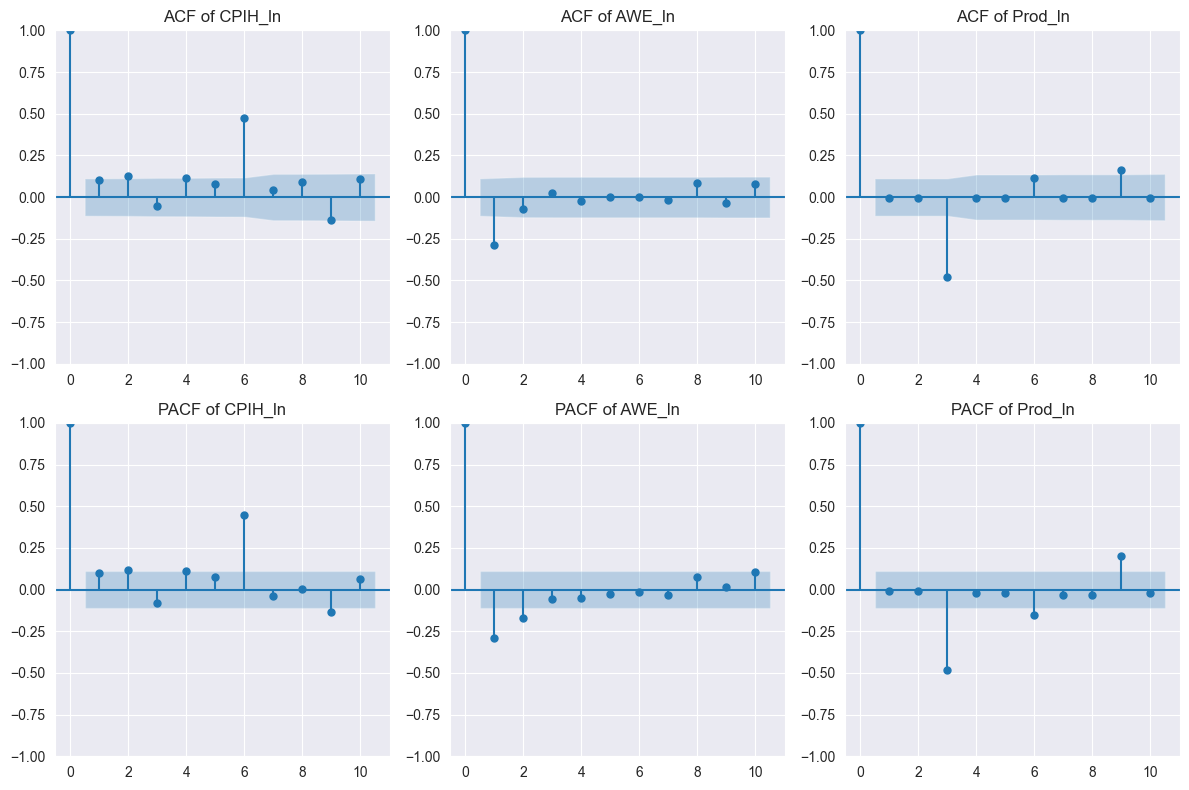

In [10]:
# Setting up plot
fig, axes = plt.subplots(2,3, figsize=(12,8))

for i, col in enumerate(cols):
    # ACF plot with 10 lags - 1st difference
    plot_acf(df_log_diff[col], lags=10, ax=axes[0,i])
    axes[0,i].set_title(f"ACF of {col}")

    # PACF plot with 10 lags
    plot_pacf(df_log_diff[col], lags=10, method="ywm", ax=axes[1,i])
    axes[1,i].set_title(f"PACF of {col}")

plt.tight_layout()
plt.show()


# Interpetation
There is no evidence in the graphs of persistent higher-order autocorrelation so we do not need to take a second difference.

# 4. Cointegration Test
Now that all the variables are stationary of order I(1) we test for cointegration, a long-term equilibrium relationship between two or more variables. We test using the Johansen trace test with lag orders from 1 to 5. We then compare the trace statistic to the 5% critical value to determine the rank of cointegration.

In [11]:
# Testing for Co-Integration
# Cointegration rank is sum of trace statistics with greater than 5% crit values

# Copying df
joh_data = df_log[cols]

# Running test and iterating over lag length
for lag in range(1,5):
    johansen_test = coint_johansen(joh_data, det_order=0, k_ar_diff=lag)
    # Taking trace statistics
    trace_stats = johansen_test.lr1
    # Taking critical values
    crit_val_5 = johansen_test.cvt[:, 1]
    # Summing conditional
    rank = np.sum(trace_stats > crit_val_5)
    print(f"Lags {lag} --> Cointegration Rank {rank}")

# Estimated cointegration rank is 2
# With 3 variables -> 2 indep. stationary long-run trends, 1 common stochastic trend

Lags 1 --> Cointegration Rank 2
Lags 2 --> Cointegration Rank 2
Lags 3 --> Cointegration Rank 0
Lags 4 --> Cointegration Rank 0


# Interpetation
The cointegration rank we found is of rank 2, meaning there is evidence of two long-run stationary relationships and a common stochastic trend

# Implications for Model Selection
We found that the variables are cointegrated so we choose a VECM model over a VAR in differences model.

# 5. Model Specification and First Estimate
We choose the lag order by calcualting the information criteria. AIC predicts higher lag orders while BIC predicts lower lag orders. Our first candidate model is using the predictions from the BIC metric since it is  conservative lag specifications are more appropriate for macroecnomic modeling. We have VAR(2) which translates to a VECM with 1 lag in difference and a cointegration rank of 2.

In [12]:
# Choosing lag length with VAR lag criterion
lag_order = VAR(joh_data).select_order(10)
print(lag_order.summary())
# AIC picks 7, BIC picks 1. We have VAR(2) and p-1=1 for VECM

# Creating VECM model with VAR(2) = p-1 and cointegration rank 2
vecm_model = VECM(joh_data, k_ar_diff=1, coint_rank=2, deterministic="co").fit()
print(vecm_model.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -18.88      -18.84   6.334e-09      -18.86
1       -30.82     -30.67*   4.138e-14      -30.76
2       -30.84      -30.58   4.026e-14      -30.74
3       -30.85      -30.47   4.017e-14      -30.70
4       -31.07      -30.58   3.221e-14      -30.87
5       -31.06      -30.46   3.244e-14      -30.82
6       -31.04      -30.34   3.300e-14      -30.76
7      -31.27*      -30.45  2.623e-14*     -30.94*
8       -31.23      -30.30   2.747e-14      -30.85
9       -31.21      -30.17   2.785e-14      -30.80
10      -31.26      -30.10   2.671e-14      -30.79
--------------------------------------------------
Det. terms outside the coint. relation & lagged endog. parameters for equation CPIH_ln
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

# Model Interpetation
## Short-Run Dynamics
### CPIH
+ Lagged short-run terms are not statistically significant
+ Inflation is weakly autoregressive
+ Long-run equilibrium adjustment is the main driver of inflation

### AWE
+ **L1.CPIH_ln=0.392 (p = 0.01)**
+ **L1.AWE_ln = -0.272 (p <0.001)**
+ Wages have a positive response to lagged (past) inflation
+ Lagged wages are strongly negative which signals a mean reversion in wage growth
+ Productivity is not significant in the short-run

### Productivity
+ Constant is significant, no significant coefficients
+ No short-run responses to inflation or wage growth
+ Exogenous growth in the short run

## Adjustments to long-run equilibria (a)
### CPIH
+ **ec1 = -0.022 (p=0.004)**
+ **ec2 = 0.022 (p=0.011)**
+ Long-run adjustments to CPIH are significant for both cointegrated variables
+ ec1 implies that as CPIH sits above long-run equilibrium, inflation (CPIH growth) falls to bring back to equilibrium
+ Strong signal towards inflation being endogenous in the long run

### AWE
+ **ec1 = 0.051 (p=0.011)**
+ **ec2 = -0.058 (p=0.013)**
+ In disequilibrium wages are a key error-correcting variable
+ First coefficient is positive, second is negative -- textbook long-run mechanism to stabilise equilibrium
+ In the long-run, wages respond to both prices and productivity

### Productivity
+ ec1 = -0.03 (p=0.054)
+ **ec2 = 0.04 (p=0.023)**
+ In the first equilibrium productivity adjustment is weak
+ Productivity adjustment is significant in the second equilibrium
+ Less responsive than wages but not fully exogenous

## Cointegrating relationships (β)
$$ \text{CPIH} - 6.66 * \text{Prod} =0 $$
+ Higher productivity lowers prices in equilibrium
+ Represents supply-side cost dynamics (unit cost)

$$ \text{AWE} - 6.98 * \text{Prod} =0 $$
+ Productivity gains are passed on to wages in the long-run
+ While wages can deviate in short run they gravitate around level determined by productivity
+ Consistent with MRP and efficiency wage theory

# 6. Residual Diagnostics
We look for any clear long-term trends by plotting the residuals of the VECM and their autocorrelation plots. The results are inconclusive.

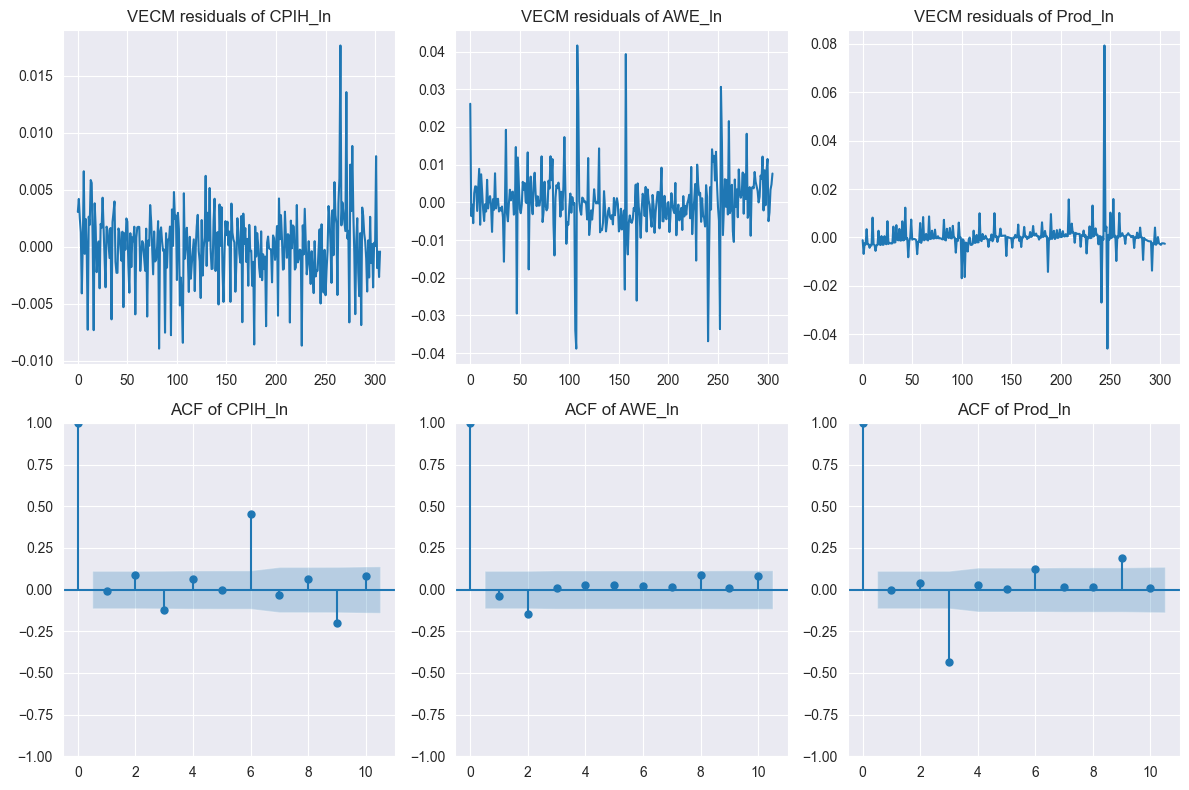

In [13]:
# Plotting residuals
resid = vecm_model.resid
cols_resid = joh_data.columns

# Setting up subplot
fig, axes = plt.subplots(2,3, figsize=(12,8))

# Iterating over index and column label
for i, col in enumerate(cols_resid):
    # Defining top row
    t_row = axes[0, i]

    # Residuals time series
    t_row.plot(resid[:, i])
    t_row.set_title(f"VECM residuals of {col}")

    # ACF plots of residuals
    plot_acf(resid[:, i], lags=10, ax=axes[1,i])
    axes[1,i].set_title(f"ACF of {col}")

plt.tight_layout()
plt.show()


# Whiteness Test
Since the residual plots are inconclusive we formally test for **residual autocorrelation** using the multivariate Portmanteau test (Whiteness test). We discover significant residual autocorrelation and estimate 3 additional models, increasing the lag length by 1 in each iteration. We find that the critical value falls with each iteration so the residual whiteness is increasing. The model we choose is a VECM(3) to prevent overfitting.

In [14]:
# Testing with white's test
print(vecm_model.test_whiteness(nlags=10))
# Reject the null, residual autocorrelation is significant
# We run again with VAR(3)

vecm_model_2 = VECM(joh_data, k_ar_diff=2, coint_rank=2, deterministic="co").fit()
print(vecm_model_2.test_whiteness(nlags=10))

vecm_model_3 = VECM(joh_data, k_ar_diff=3, coint_rank=2, deterministic="co").fit()
print(vecm_model_3.test_whiteness(nlags=10))

vecm_model_4 = VECM(joh_data, k_ar_diff=4, coint_rank=2, deterministic="co").fit()
print(vecm_model_4.test_whiteness(nlags=10))

# Test statistics is falling. VAR(5) is probably overfitting, use VAR(4) so vecm_model_3

<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 230.986, critical value: 96.217>, p-value: 0.000>
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 212.395, critical value: 85.965>, p-value: 0.000>
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 138.636, critical value: 75.624>, p-value: 0.000>
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 10 is zero: reject at 5% significance level. Test statistic: 122.131, critical value: 65.171>, p-value: 0.000>


# 7. Forecasting
We forecast 12 months in advance using the VECM(3) model with a cointegration of rank 2. We convert into a dataframe and plot the observed and forecasted values, over the past 5 years.

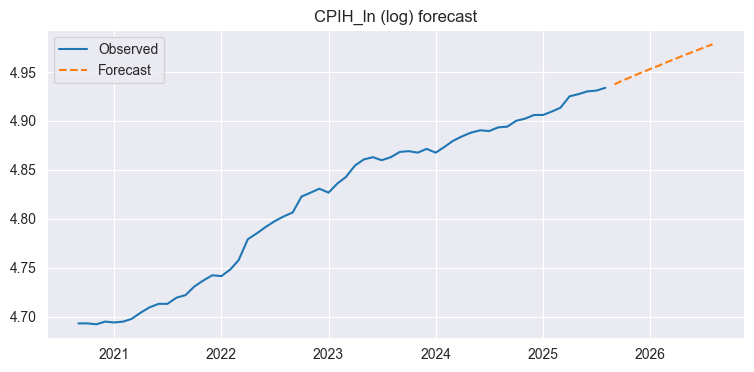

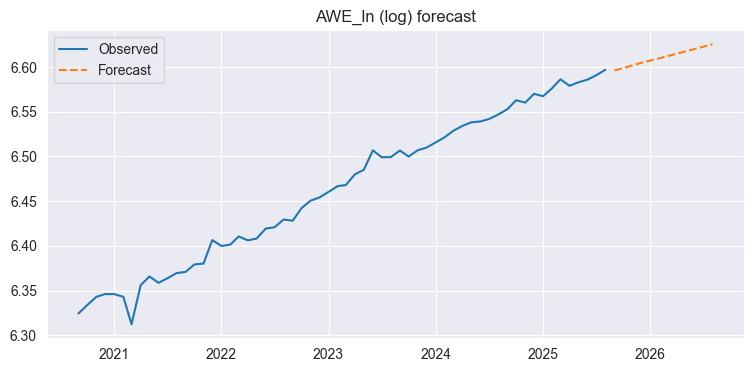

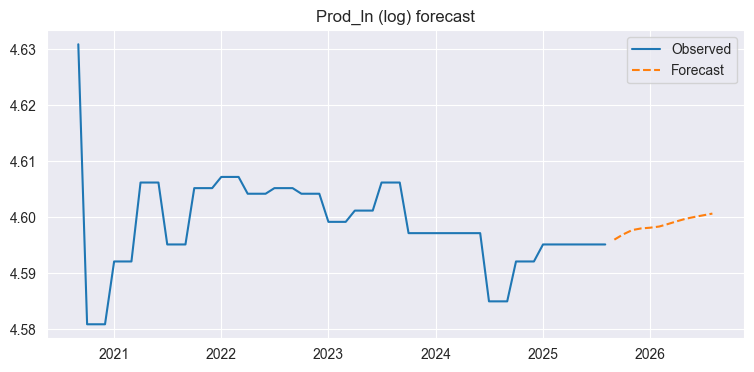

In [15]:
# Forecasting
forecast = vecm_model_3.predict(steps=12)

# Constructing index
forecast_idx = pd.date_range(
    start=joh_data.index[-1],
    periods=13,
    freq=joh_data.index.freq
)[1:]

# Wrapping into dataframe
forecast_df = pd.DataFrame(
    forecast,
    index=forecast_idx,
    columns=joh_data.columns
)

# Setting cutoff point to be the last 5 years
cutoff = joh_data.index[-60]

# Plotting observed and predicted
for col in joh_data.columns:
    plt.figure(figsize=(9,4))
    plt.plot(joh_data.loc[cutoff:,col], label="Observed")
    plt.plot(forecast_df[col], linestyle="--", label="Forecast")
    plt.title(f"{col} (log) forecast")
    plt.legend()
    plt.show()

# Forecast Interpetation
CPIH is increasing smoothly over time, with a forecasted smooth upward trend. Inflation is expected to remain positive and stable. AWE is persistent and increasing smoothly. Little volatility in observed and forecasted trend. Short-run shocks stabilise in the long-run and follow productivity. Productivity has a weak trend and low volatility. The forecast predicts smooth and comparatively small growth in productivity. Overall, productivity is evolving gradually, wage shocks are dissapating quickly and strongly back to long-run equilibria and the price level is increasing smoothly. Forecast predicts stable development over the forecast horizon with long-run cointegrating relationships dominating short-run dynamics.

# 8. Model Evaluation
Since we don't have future observations we can create a pseudo in-sample set to train our model on in order to predict the out-of-sample-observations. We choose a random date (06/04/2017) to set the cut-off point for the training data. All the observations prior and including that date are used to train the model and the 12 observations after are used to test it. Our metric is Root Mean Squared Error (RMSE). We calculate the RMSE for each variable which is a solid representation of model accuracy.

In [16]:
# Pseudo out-of-sample prediction
in_sample = "2017-04-01"

# Splitting into training and test data
train = joh_data.loc[:in_sample]
# Test data stops after 12 months
test = joh_data.loc[in_sample:].iloc[:12]

# VECM with VAR(4) on training
vecm_train = VECM(train, k_ar_diff=3, coint_rank=2, deterministic="co").fit()

# Forecasting
forecast_test = vecm_train.predict(steps=12)

# Converting into df
forecast_test_df = pd.DataFrame(
    forecast_test,
    index=test.index,
    columns=joh_data.columns
)

# Calculating RMSE
for col in cols:
    rmse = np.sqrt(
        np.mean((forecast_test_df[col] - test[col]) ** 2)
    )
    print(f"RMSE for {col} is {rmse: .4f} -- {rmse*100: .2f}% level error")

RMSE for CPIH_ln is  0.0019 --  0.19% level error
RMSE for AWE_ln is  0.0031 --  0.31% level error
RMSE for Prod_ln is  0.0112 --  1.12% level error


# RMSE interpretation
For the CPIH and AWE the level error is less than 1%, the model is very accurate. For productivity since the data wasn't monthly we expect a fair amount of noise to be impacting the error which is a little over 1%.

# 9. Conclusion
We found cointegration between inflation, weekly earnings and productivity, as was expected on the basis of economic theory. We used a VECM model to capture the long-run equilibrium relationships along with the short-run dynamics and forecasted the following 12 months. We then tested the model's strength using a pseudo out-of-sample approach and found the margin of error to be minimal. What remains is to test the model with actual data in 2026.